<a href="https://colab.research.google.com/github/map72ru/biz_learn/blob/main/NNW_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра 
свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
*   оценить рост точности при увеличении ширины сети (больше ядер)
*   оценить рост точности при увеличении глубины сети (больше слоев)
*   (опциционально)сравнить с точностью полносвязной сети для этой выборки

In [1]:
from __future__ import print_function
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import tensorflow.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [3]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [4]:
batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = False
num_predictions = 20

In [5]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)


x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


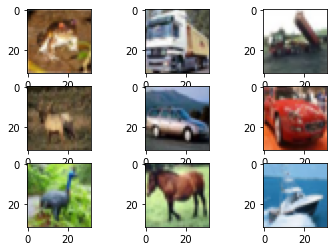

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

#Plot data
for i in range(0,9):
  plt.subplot(330+1+i)
  plt.imshow(x_train[i])
plt.show() 

In [28]:
#Define Alexnet Model
def AlexnetModel(input_shape,num_classes, sm = 0, add_layers = 0):
  model = Sequential()
  model.add(Conv2D(filters=96 + sm,kernel_size=(3,3),strides=(4,4),input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(256+sm,(5,5),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(384+sm,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(384+sm,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(256+sm,(3,3),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  for l in range(0, add_layers):
    model.add(Conv2D(128+(sm//2), (3,3),padding='same',activation='relu'))
  if add_layers > 0:
    model.add(MaxPooling2D(pool_size=(1,1),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(4096 + sm*5, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(4096 + sm*5, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes,activation='softmax'))

  return model

In [7]:
input_shape = (32, 32, 3)
model = AlexnetModel(input_shape, num_classes)

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss= 'categorical_crossentropy' , optimizer=optimizer, metrics=[ 'accuracy' ])
print("Model Summary of ")
print(model.summary())

Model Summary of 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 96)          2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 2,

In [8]:
#Data Normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255.
x_test = x_test/255.

x_train_mean = np.mean(x_train)
x_train -= x_train_mean
x_test_mean = np.mean(x_test)
x_test -= x_test_mean

print(y_train.shape, y_test.shape)

(50000, 10) (10000, 10)


In [9]:
save_dir = os.path.join(os.getcwd(), 'saved_models')

#model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
model_name = 'alexnet_model.{epoch:03d}.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [10]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler,early_stopping]

In [19]:
model = AlexnetModel(input_shape, num_classes)
model.compile(loss= 'categorical_crossentropy' , optimizer=optimizer, metrics=[ 'accuracy' ])
print("Model Summary of ")
print(model.summary())
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)

Model Summary of 
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 8, 8, 96)          2688      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 4, 4, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 2, 2, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 2, 2, 384)         885120    
                                                                 
 conv2d_23 (Conv2D)          (None, 

In [20]:
history.history

{'accuracy': [0.12291999906301498,
  0.29763999581336975,
  0.41471999883651733,
  0.4707399904727936,
  0.5116999745368958,
  0.5387399792671204,
  0.5612199902534485,
  0.5761399865150452,
  0.5903000235557556,
  0.6030799746513367],
 'loss': [2.2350525856018066,
  1.77940034866333,
  1.5480237007141113,
  1.4128435850143433,
  1.3331034183502197,
  1.273060917854309,
  1.2219146490097046,
  1.1828373670578003,
  1.1483268737792969,
  1.1200835704803467],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
 'val_accuracy': [0.2079000025987625,
  0.3772999942302704,
  0.44290000200271606,
  0.503000020980835,
  0.5031999945640564,
  0.5349000096321106,
  0.554099977016449,
  0.5565999746322632,
  0.5619000196456909,
  0.5687000155448914],
 'val_loss': [1.9369796514511108,
  1.6266573667526245,
  1.459326148033142,
  1.3375428915023804,
  1.3252687454223633,
  1.2950074672698975,
  1.249984860420227,
  1.2462776899337769,
  1.2441482543945312,
  1.22597777843

In [16]:
def print_result(history):
# list all data in history
  print(history.history.keys())
# summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
# summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


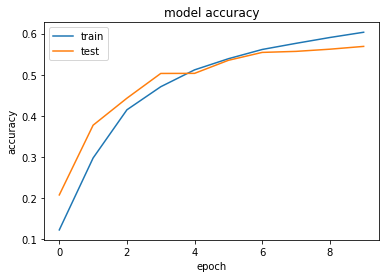

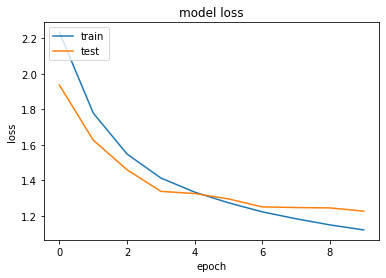

In [21]:
print_result(history)

In [13]:
# Увеличим количество ядер
model_1 = AlexnetModel(input_shape, num_classes, 50)
model_1.compile(loss= 'categorical_crossentropy' , optimizer=optimizer, metrics=[ 'accuracy' ])
print("Model Summary of ")
print(model_1.summary())
history = model_1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)

Model Summary of 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 8, 8, 146)         4088      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 146)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 306)         1117206   
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 2, 2, 306)        0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 2, 2, 434)         1195670   
                                                                 
 conv2d_13 (Conv2D)          (None, 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


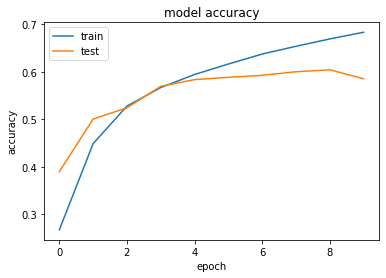

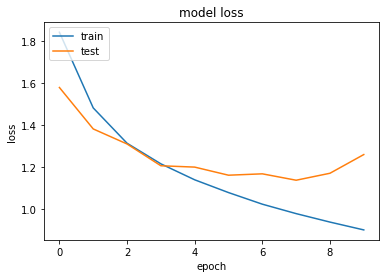

In [17]:
print_result(history)

Увеличение ядер привело к существенному росту точности

In [29]:
# Увеличим количество слоев
model_2 = AlexnetModel(input_shape, num_classes, 50, 2)
model_2.compile(loss= 'categorical_crossentropy' , optimizer=optimizer, metrics=[ 'accuracy' ])
print("Model Summary of ")
print(model_2.summary())
history = model_2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)

Model Summary of 
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 8, 8, 146)         4088      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 4, 4, 146)        0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 4, 4, 306)         1117206   
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 2, 2, 306)        0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 2, 2, 434)         1195670   
                                                                 
 conv2d_54 (Conv2D)          (None, 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


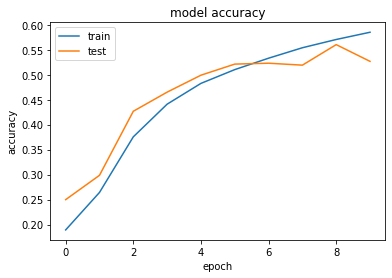

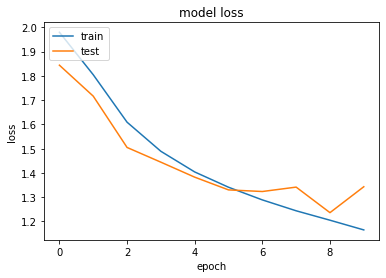

In [30]:
print_result(history)

Увеличение слоев не привело к увеличению точности.

In [41]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [50]:
a = x_train.reshape((-1, 3*1024))

In [51]:
a.shape

(50000, 3072)

In [9]:
# Flatten the images.
train_images = x_train.reshape((-1, 3*1024))
test_images = x_test.reshape((-1, 3*1024))  

model_seq = Sequential()
model_seq.add(Dense(128, activation='tanh', input_shape=(3072,)))
model_seq.add(Dense(110, activation='tanh')) 
model_seq.add(Dense(100, activation='tanh')) 
model_seq.add(Dense(10, activation='softmax'))

model_seq.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_seq.fit(train_images[:,:], y_train[:,:], epochs=10, batch_size=2048, verbose=0)

results = model_seq.evaluate(test_images[:,:], y_test[:,:], batch_size=128)


79/79 [==============================] - 0s 4ms/step - loss: 0.3179 - accuracy: 0.1399


Точность получилась ниже чем даже у самой простой сверточной сети